In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64
import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
path = Path('../input')
tfms = get_transforms(do_flip=True , flip_vert= True , max_rotate=10.0 , max_zoom=1.1 , 
                     max_lighting =0.2 , max_warp = 0.2 , p_affine = 0.75 , p_lighting = 0.75)


In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [4]:
train.head(2)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1


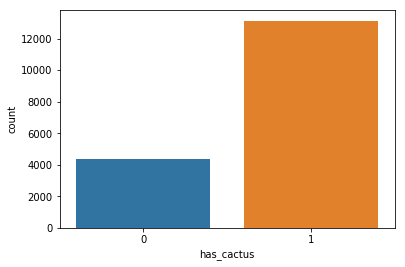

In [5]:
sns.countplot(x= 'has_cactus' , data = train)

In [6]:
no_cactus = train.query("has_cactus == 0")
train = train.append([no_cactus]*2, ignore_index=True)

In [7]:
np.random.seed(2000)
data = (ImageList.from_df(train , path = path/'train' , folder = 'train')
       .split_by_rand_pct(0.01)
        .label_from_df()
        .transform(tfms, size=128)
        .databunch(path='.', bs=bs, device= torch.device('cuda:0'))
                  ).normalize(imagenet_stats)

In [8]:
#data.show_batch(rows=3, fig_size=(7, 7))

In [9]:
learn = cnn_learner(data , models.densenet161 , metrics = error_rate)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 82982428.81it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


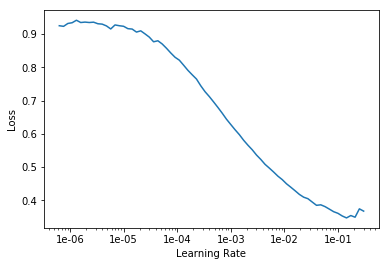

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
#learn.fit_one_cycle(5, slice(3e-02))

In [12]:
#learn.recorder.plot_losses()

In [13]:
#learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


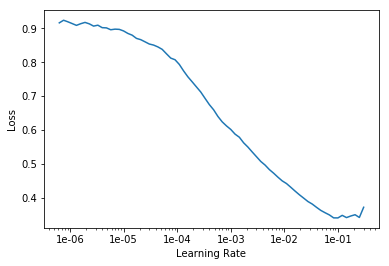

In [14]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.864389,0.765516,0.484733,01:46


In [ ]:
learn.recorder.plot_losses()

In [ ]:
test_data = ImageList.from_df(test, path=path/'test', folder='test')
data.add_test(test_data)

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
test.has_cactus = preds.numpy()[:, 0]

In [ ]:
test.to_csv("submit.csv", index=False)

In [ ]:
preds